In [24]:
# Import
from pyRSD import pygcl
import matplotlib.pyplot as plt

# from nbodykit.lab import *
import numpy as np
from pyRSD.rsdfit.data import PowerMeasurements
from pyRSD.rsdfit import FittingDriver

plt.rcParams['figure.figsize']        = 6., 4.
# plt.rcParams['figure.subplot.left']   = 0.125
# plt.rcParams['figure.subplot.right']  = 0.9
# plt.rcParams['figure.subplot.bottom'] = 0.125
# plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

# nowiggle = False
nowiggle = True

In [46]:
k

array([0.0227174, 0.0276293, 0.0326248, 0.0375813, 0.0426003, 0.0475911,
       0.0525713, 0.0575652, 0.0625597, 0.0675703, 0.0725781, 0.0775834,
       0.0825811, 0.0875584, 0.0925584, 0.0975456, 0.102543 , 0.107557 ,
       0.112556 , 0.11754  , 0.122527 , 0.127532 , 0.132518 , 0.137523 ,
       0.142529 , 0.147539 , 0.15255  , 0.157538 , 0.162538 , 0.167531 ,
       0.172521 , 0.177529 , 0.182522 , 0.187514 , 0.192517 , 0.197508 ,
       0.202518 , 0.207522 , 0.212529 , 0.217537 , 0.222519 , 0.227517 ,
       0.232511 , 0.237506 , 0.242517 , 0.247517 , 0.25252  , 0.25751  ,
       0.262513 , 0.267521 , 0.272513 , 0.277514 , 0.282514 , 0.287515 ,
       0.29252  , 0.297516 , 0.302516 , 0.307514 , 0.312514 , 0.317516 ,
       0.322514 , 0.327513 , 0.332512 , 0.337515 , 0.342513 , 0.347512 ,
       0.352517 , 0.35751  , 0.362505 , 0.367501 , 0.372503 , 0.37751  ,
       0.382513 , 0.387512 , 0.392512 , 0.397514 ])

## Load fitting driver from previous fits

In [25]:
# Result file path
results_file = '2022-02-22_nlopt_59i_chain0__1.npz'
model_file = 'Run1_Model_LOWZ_N.npy'
dirname='/pscratch/sd/g/gstein/machine_learning/pae/pyrsd_emulator/data/construct_pyrsd_data'

# Specify model + result file paths
d = FittingDriver.from_directory(dirname=dirname, model_file=model_file, results_file=results_file)
d.set_fit_results()

# Set no wiggle transfer function, as we will be adding wiggles back in during inference (they only minimally change results)
# Set the transfer function as Eisenstein & Hu + no wiggle
if nowiggle:
    d.theory.model.cosmo.SetTransferFunction(tf=pygcl.transfers.EH_NoWiggle)

# P(k) best-fit model
model_d = d.theory.model
cosmo = d.theory.model.cosmo

In [26]:
# Load best-fit (unconvolved) P_ell's
from pyRSD.rsd.transfers import WindowFunctionTransfer

k = np.logspace(-3, 0, 1000)

def get_Pells(d, k, multipole_orders=[0, 2, 4]):

    Pell = np.stack([d.theory.model.poles(k, m)[:,0] for m in multipole_orders])
    
    return Pell

def get_Pells_lin(d, k):
    cosmo_d = d.theory.model.cosmo
    cosmo_d_clone = cosmo_d.clone(tf=pygcl.transfers.EH_NoWiggle)
    linpower_z1 = pygcl.LinearPS(cosmo_d_clone, d.model.z)
    linpower_z1.SetSigma8AtZ(d.theory.fit_params['sigma8_z'].value)

    b = d.theory.fit_params['b1'].value
    f = d.theory.fit_params['f'].value

    lin = linpower_z1(k)
    lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
    lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
    lin4 = (8/35*f**2)*lin  

    Pell_lin = np.stack([lin0, lin2, lin4])
    
    return Pell_lin

def convolve_Pell(d, k, Q=None):
    
    if Q is None:
        Q = np.loadtxt('wcp_rd10_DDsmu_PATCHY_6C_wxw_North_0.2-0.5_normed.dat')
    
    ells = [0, 2, 4]
    Nk = 1024
    Nmu = 2000

    # Use a transfer function to convolve with the window function
    transfer = WindowFunctionTransfer(Q, ells, kmin=1e-4, kmax=1, Nk = Nk, Nmu = Nmu, max_ellprime = 4)
    mu = np.linspace(0, 1., Nmu)
    k_pole_pkmu = np.logspace(-4, 0, Nk)

    # P(k,mu)
    Pkmu = d.theory.model.power(k_pole_pkmu, mu)

    # P_ell's
    Pell_convolved = transfer(Pkmu, k).T
    
    return Pell_convolved


Pell = get_Pells(d, k)
Pell_convolved = convolve_Pell(d, k)

Pell_lin = get_Pells_lin(d, k)

print(Pell.shape, Pell_convolved.shape, Pell_lin.shape)

(3, 1000) (3, 1000) (3, 1000)


In [27]:
np.tile(Pell_lin[0], 2048).shape
k.shape

(1000,)

In [28]:
ells = [0, 2, 4]
Nk = 1024
Nmu = 2000

Q = np.loadtxt('wcp_rd10_DDsmu_PATCHY_6C_wxw_North_0.2-0.5_normed.dat')

# Use a transfer function to convolve with the window function
transfer = WindowFunctionTransfer(Q, ells, kmin=1e-4, kmax=1, Nk = Nk, Nmu = Nmu, max_ellprime = 4)

# P_ell's
Pell_lin_convolved = transfer(np.tile(Pell_lin[0], 2048), k).T 
Pell_lin_convolved.shape


(3, 1000)

In [29]:
# Load the data
data = np.loadtxt('Pell_avgmock1000_z1_NGC_6S.dat')
k_N1 = data[0:76,0]
P0_dat = data[0:len(k_N1),1]
P2_dat = data[len(k_N1):2*len(k_N1),1]
P4_dat = data[2*len(k_N1):3*len(k_N1),1]

# Load the covariance (reduced by np.sqrt(1000) - avg of 1000 sims)
from pyRSD.rsdfit.data import PoleCovarianceMatrix
cov_analytic_N1 = PoleCovarianceMatrix.from_plaintext('reducebysq1000_data_covariance_PATCHY_z1NGC.dat')
err_P0_dat = np.sqrt(cov_analytic_N1[0:len(k_N1), 0:len(k_N1)].diagonal())
err_P2_dat = np.sqrt(cov_analytic_N1[len(k_N1):2*len(k_N1), len(k_N1):2*len(k_N1)].diagonal())
err_P4_dat = np.sqrt(cov_analytic_N1[2*len(k_N1):3*len(k_N1), 2*len(k_N1):3*len(k_N1)].diagonal())

In [30]:
# Linear Power using the fitted cosmology (using Eisenstein & Hu no wiggle transfer function)
cosmo_d = d.theory.model.cosmo
cosmo_d_clone = cosmo_d.clone(tf=pygcl.transfers.EH_NoWiggle)
linpower_z1 = pygcl.LinearPS(cosmo_d_clone, d.model.z)
linpower_z1.SetSigma8AtZ(d.theory.fit_params['sigma8_z'].value)

b = d.theory.fit_params['b1'].value
f = d.theory.fit_params['f'].value

lin = linpower_z1(k)
lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
lin4 = (8/35*f**2)*lin  

Pell_lin = np.stack([lin0, lin2, lin4])

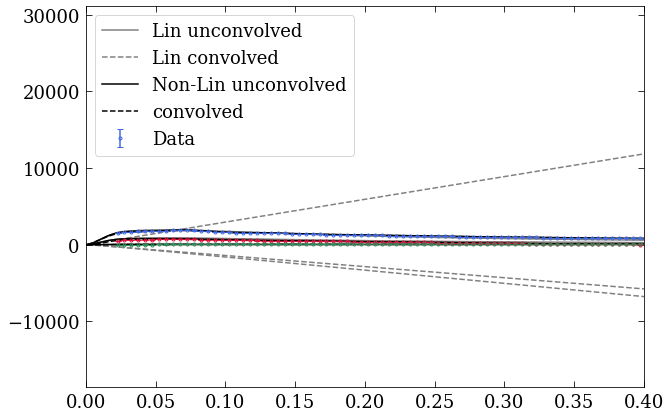

In [31]:
plt.figure(figsize=(10,7))

# Plot the data
plt.errorbar(k_N1, k_N1*P0_dat, yerr = k_N1*err_P0_dat, fmt='.', mfc='None', mec='royalblue', ecolor = 'royalblue', capsize = 3.0, label = 'Data', zorder=10)
plt.errorbar(k_N1, k_N1*P2_dat, yerr = k_N1*err_P2_dat, fmt='.', mfc='None', mec='crimson', ecolor = 'crimson', capsize = 3.0, label = None, zorder=10)
plt.errorbar(k_N1, k_N1*P4_dat, yerr = k_N1*err_P4_dat, fmt='.', mfc='None', mec='seagreen', ecolor = 'seagreen', capsize = 3.0, label = None, zorder=10)

# Plot the unconvolved linear theory
plt.plot(k, k*Pell_lin[0], ls='-', color='gray', label='Lin unconvolved')
plt.plot(k, k*Pell_lin[1], ls='-', color='gray')
plt.plot(k, k*Pell_lin[2], ls='-', color='gray')

# Plot thenconvolved linear theory
plt.plot(k, k*Pell_lin_convolved[0], ls='--', color='gray', label='Lin convolved')
plt.plot(k, k*Pell_lin_convolved[1], ls='--', color='gray')
plt.plot(k, k*Pell_lin_convolved[2], ls='--', color='gray')

# Plot the unconvolved non-linear theory
plt.plot(k, k*Pell[0], 'k-', label='Non-Lin unconvolved')
plt.plot(k, k*Pell[1], 'k-')
plt.plot(k, k*Pell[2], 'k-')

# Plot the convolved theory
plt.plot(k, k*Pell_convolved[0], 'k--', label='convolved')
plt.plot(k, k*Pell_convolved[1], 'k--')
plt.plot(k, k*Pell_convolved[2], 'k--')

plt.xlim(0, 0.4)
# plt.yscale('log')
plt.legend()

In [32]:
Pell.shape, Pell_lin.shape

((3, 1000), (3, 1000))

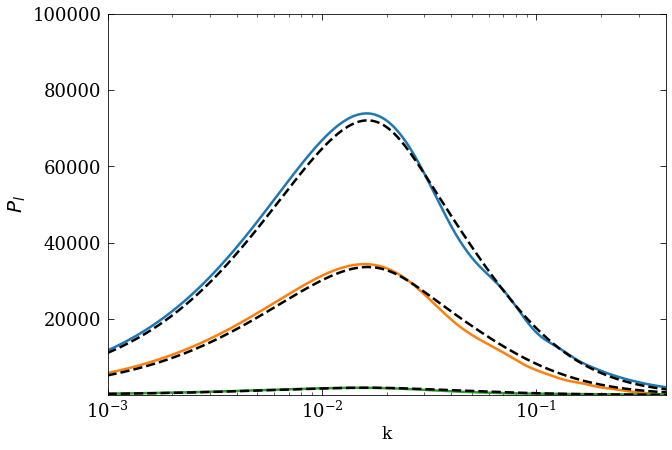

In [35]:
# Plot k vs. P_l

plt.figure(figsize=(10,7))
for m in range(3):
    plt.loglog(k, Pell[m], '-', color = f'C{m}', lw=2.5)
    plt.loglog(k, Pell_lin[m], '--', color = 'k', lw=2.5)

plt.xlim(1e-3, 0.4)
plt.ylim(1e2, 1e5)
plt.ylabel('$P_l$', fontsize=20)
plt.xlabel('k', fontsize=17)
plt.yscale('linear')

Text(0.5, 0, 'k')

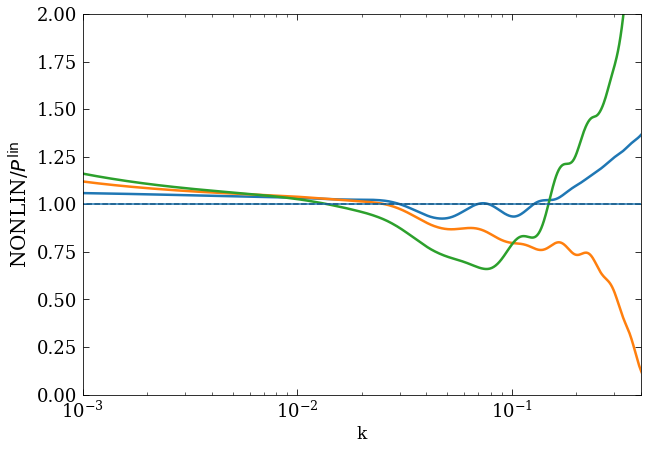

In [36]:
# Plot Nonlinear/Linear ratio

plt.figure(figsize=(10,7))
for m in range(3):
    plt.plot(k, Pell[m]/Pell_lin[m], '-', color = f'C{m}', lw=2.5)

xx = np.linspace(0, 0.5, 100)
plt.plot(xx, np.ones(100), 'k--')
plt.semilogx(k, np.ones(1000))
plt.xlim(1e-3, 0.4)
plt.ylim(0, 2)
plt.ylabel('NONLIN/$P^{\mathrm{lin}}$', fontsize=20)
plt.xlabel('k', fontsize=17)

## Look at uncertainty

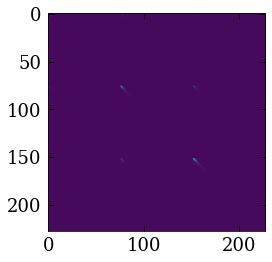

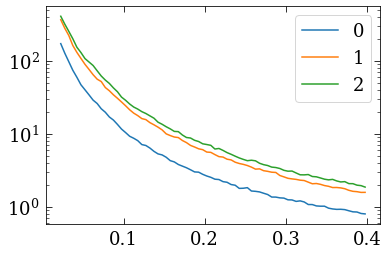

In [37]:
k = k_N1
cov = d.data.covariance_matrix.values
cov_inv = d.data.covariance_matrix.inverse
sigma = np.sqrt(cov.diagonal()).reshape(3, -1)
np.savez("../p0-p2-p4_cov.npz",
         k=k_N1,
         cov=cov,
         cov_inv=cov_inv,
         sigma=sigma,
        )
plt.imshow(cov)

plt.figure()
for i in range(sigma.shape[0]):
    plt.semilogy(k, sigma[i], label=f"{i}")
plt.legend()

In [38]:
d.theory.fit_params

name,value,initial value,min,max,vary,expression
F_AP,1.00000000,None,-inf,inf,False,alpha_par/alpha_perp
N,0.00000000,0.0,-inf,inf,False,
NcBs,145219.959,45000.0,-inf,inf,False,f1h_cBs / (fcB*(1 - fs)*nbar)
NsBsB,103495.843,94500.0,-inf,inf,False,f1h_sBsB / (fsB**2 * fs**2 * nbar) * (fcB*(1 - fs) - fs*(1-fsB))
Nsat_mult,2.40409096,2.4,2.00000000,inf,True,
alpha,1.00000000,None,-inf,inf,False,(alpha_perp**2 * alpha_par)**(1./3)
alpha_drag,1.00000000,1.0,-inf,inf,False,
alpha_par,1.00000000,1.0,-inf,inf,False,
alpha_perp,1.00000000,1.0,-inf,inf,False,
b1,1.69105756,None,-inf,inf,False,(1 - fs)*b1_c + fs*b1_s


In [39]:
# Get params and their priors and put in dictionary
params = d.theory.fit_params
# use all varied params
names  = [k for k in params if params[k].vary] 

# names = ['sigma8_z', 'f', 'b1_cA']
values = [params[i].value for i in names] 
priors = [params[i].prior for i in names] 

param_priors = {}
for i in range(len(names)):
    
    name = names[i]
    value = values[i]
    prior = priors[i]

    try:
        prior_type = 'normal'
        prior_vals = [prior.mu, prior.sigma]
    except:
        prior_type = 'uniform'
        prior_vals = [prior.lower, prior.upper]
        
    param_priors[name] = {
        'value': value,
        'prior': prior_type,
        'prior_vals': prior_vals,
    }
    
param_priors['sigma8_z']['prior_vals'][0] = 0.5
param_priors

{'Nsat_mult': {'value': 2.4040909618597026,
  'prior': 'normal',
  'prior_vals': [2.4, 0.2]},
 'b1_cA': {'value': 1.5657029077250786,
  'prior': 'uniform',
  'prior_vals': [1.2, 2.5]},
 'f': {'value': 0.6527528891436477,
  'prior': 'uniform',
  'prior_vals': [0.6, 1.0]},
 'f1h_sBsB': {'value': 3.9238303370686025,
  'prior': 'normal',
  'prior_vals': [4.0, 1.0]},
 'fs': {'value': 0.051620638641754035,
  'prior': 'uniform',
  'prior_vals': [0.0, 0.25]},
 'fsB': {'value': 0.979723456922603,
  'prior': 'uniform',
  'prior_vals': [0.0, 1.0]},
 'gamma_b1sA': {'value': 1.4586847999857098,
  'prior': 'normal',
  'prior_vals': [1.45, 0.3]},
 'gamma_b1sB': {'value': 2.10462268759816,
  'prior': 'normal',
  'prior_vals': [2.05, 0.3]},
 'sigma8_z': {'value': 0.7381751882968806,
  'prior': 'uniform',
  'prior_vals': [0.5, 0.9]},
 'sigma_c': {'value': 1.4745426397353925,
  'prior': 'uniform',
  'prior_vals': [0.0, 3.0]},
 'sigma_sA': {'value': 1.2742081601473432,
  'prior': 'uniform',
  'prior_vals'

In [40]:
names

['Nsat_mult',
 'b1_cA',
 'f',
 'f1h_sBsB',
 'fs',
 'fsB',
 'gamma_b1sA',
 'gamma_b1sB',
 'sigma8_z',
 'sigma_c',
 'sigma_sA']

In [41]:
# Sample new model parameters from prior
def sample_params_from_priors(params: dict):
    """
    params is a dictionary with parameter name as key, and prior/prior_vals as items
    """
    sample = {}
    for k in params:
        if params[k]['prior'] == 'uniform':
            lower, upper = params[k]['prior_vals']
            val = np.random.uniform(lower, upper)
        if params[k]['prior'] == 'normal':
            mu, sig = params[k]['prior_vals']
            val = np.random.normal(mu, sig)
                       
        sample[k] = val
        
    return sample

def update_model_params(sample, model):
    for param in sample:

        if param =='Nsat_mult': 
            model.Nsat_mult = sample[param]

        if param == 'b1_cA': 
            model.b1_cA = sample[param]

        if param == 'f': 
            model.f = sample[param]

        if param == 'f1h_sBsB':
            model.f1h_sBsB = sample[param]

        if param == 'fs':
            model.fs = sample[param]

        if param == 'fsB': 
            model.fsB = sample[param]

        if param == 'gamma_b1sA': 
            model.gamma_b1sA = sample[param]

        if param == 'gamma_b1sB': 
            model.gamma_b1sB = sample[param]

        if param == 'sigma8_z': 
            model.sigma8_z = sample[param]

        if param == 'sigma_c': 
            model.sigma_c = sample[param]

        if param == 'sigma_sA': 
            model.sigma_sA = sample[param]

    # return model

def update_fitted_model_params(sample, model):
    for param in sample:
        model[param].value = sample[param]

  
sample_params_from_priors(param_priors)

{'Nsat_mult': 2.589995455256647,
 'b1_cA': 1.2026424347501596,
 'f': 0.9028463023573389,
 'f1h_sBsB': 3.2277270690039876,
 'fs': 0.07154049103789145,
 'fsB': 0.26054042272114375,
 'gamma_b1sA': 1.4857616954532298,
 'gamma_b1sB': 1.8906847484903218,
 'sigma8_z': 0.5216849921816357,
 'sigma_c': 1.000035244534799,
 'sigma_sA': 5.57544364057456}

In [42]:
# d.theory.model.cosmo.f_z
d.theory.model.b1

2.0

['k', 'cov', 'cov_inv', 'sigma']


Text(0, 0.5, '$P^{\\mathrm{non-lin}}$/$P^{\\mathrm{lin}}$')

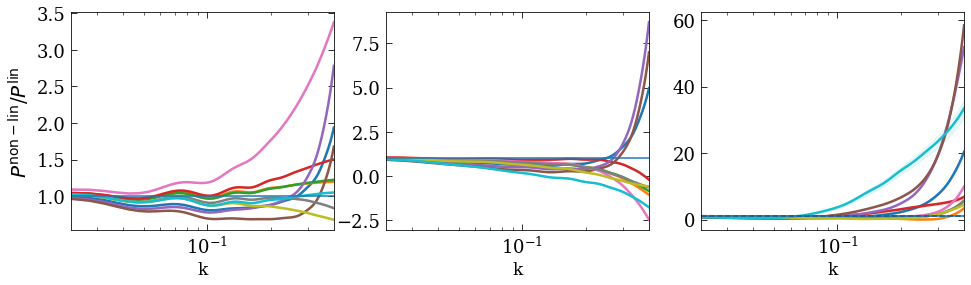

In [43]:
import time


nsamples = 10
kbin_data = np.load("../p0-p2-p4_cov.npz")
        #  k=k,
        #  cov=cov,
        #  cov_inv=cov_inv,
        #  sigma=sigma,
        # )
print(kbin_data.files)        
k = kbin_data['k']
P_err = kbin_data['sigma']

nk = k.shape[0]
kmin = k[0]
kmax = k[-1]

fig, ax = plt.subplots(1, 3, figsize=(16,4))
np.random.seed(13579)

for i in range(nsamples):
    
    sample = sample_params_from_priors(param_priors)
    update_fitted_model_params(sample, d.theory.fit_params)
    update_model_params(sample, model_d)
    
    model_d.b1 = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s
    d.theory.fit_params['b1'].value = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s

    # b = d.theory.fit_params['b1'].value
    # f = d.theory.fit_params['f'].value
     
    b = model_d.b1
    f = model_d.f    
    
    linpower_z1.SetSigma8AtZ(model_d.sigma8_z)

    # linpower_z1.SetSigma8AtZ(d.theory.fit_params['sigma8_z'].value)

    # Re-load best-fit (unconvolved) P_ell's
    Pell = get_Pells(d, k)
    Pell_convolved = convolve_Pell(d, k)
    
    lin = linpower_z1(k)
    lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
    lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
    lin4 = (8/35*f**2)*lin  

    Pell_lin = np.stack([lin0, lin2, lin4])
    
    Pell_ratio = Pell/Pell_lin    
    Pell_ratio_sig = np.abs(Pell_ratio) * np.sqrt( (P_err/Pell)**2 + (P_err/Pell_lin)**2)

    for m in range(3):
        ax[m].plot(
            k,
            Pell_ratio[m],
            color=f'C{i%10}',
            lw=2.5,
            label=', '.join([f'{k}={sample[k]:0.2f}' for k in sample])
        )
        ax[m].fill_between(
            k,
            Pell_ratio[m] - Pell_ratio_sig[m],
            Pell_ratio[m] + Pell_ratio_sig[m],
            color=f'C{i%10}',
            alpha = 0.1
        )   

xx = np.linspace(kmin, kmax, 100)
plt.plot(xx, np.ones(100), 'k--')
for axi in ax:
    axi.semilogx(k, np.ones(nk))
    axi.set_xlim(kmin, kmax)
    axi.set_xlabel('k', fontsize=17)

    # axi.set_ylim(0, 10)
    
ax[0].set_ylabel('$P^{\mathrm{non-lin}}$/$P^{\mathrm{lin}}$', fontsize=20)

# plt.legend(loc='upper center')

# Check how varying model params changes pk_lin and Pk_nonlin

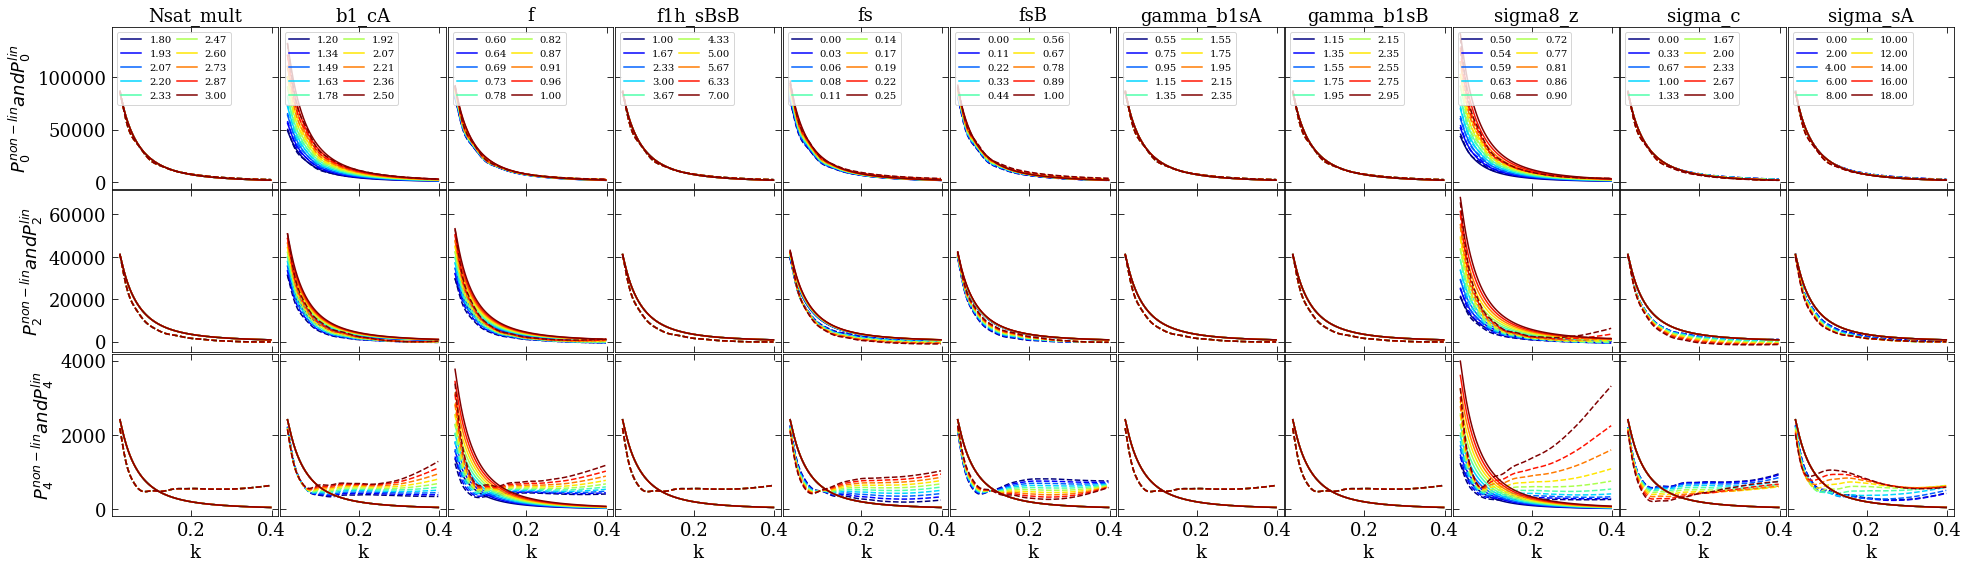

In [45]:
model_param_names = np.array(['Nsat_mult', 'b1_cA', 'f', 'f1h_sBsB', 'fs', 'fsB', 'gamma_b1sA', 'gamma_b1sB', 'sigma8_z', 'sigma_c', 'sigma_sA'], dtype='<U10')

model_params_mean = np.array([2.4 , 1.85, 0.8, 4., 0.125, 0.5, 1.45, 2.05, 0.7, 1.5, 9.0 ])
param_min = np.array([1.8, 1.2, 0.6, 1., 0., 0., 0.55, 1.15, 0.5, 0., 0. ], dtype=np.float32)
param_max = np.array([3.0, 2.5, 1., 7., 0.25, 1., 2.35, 2.95, 0.9, 3., 18. ], dtype=np.float32)

nplt = 10
multipole_order = 3
cmap = plt.cm.jet

nx = model_params_mean.shape[0]
ny = max(multipole_order, 2)

fig, ax = plt.subplots(ny, nx, figsize=(3*nx,3*ny), sharex='col', sharey='row')
plt.subplots_adjust(hspace=0.01, wspace=0.01)
for iparam in range(model_params_mean.shape[0]):
    paramsi = np.tile(model_params_mean, (nplt, 1))

    param_val_vary = np.linspace(param_min[iparam], param_max[iparam], nplt)
    paramsi[:, iparam] = param_val_vary

    paramsi_print = paramsi.copy()

    for i in range(nplt):
        
        c = (param_val_vary[i] - param_min[iparam])/(param_max[iparam] - param_min[iparam])
        # print(param_val_vary[i], param_min[iparam], param_max[iparam], c)
        lab = f'{paramsi_print[i, iparam]:.2f}'

        p = {} # make param dictionary
        for ip, param in enumerate(model_param_names):
            p[param] = paramsi[i][ip]

        update_fitted_model_params(p, d.theory.fit_params)
        update_model_params(p, model_d)

        model_d.b1 = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s
        d.theory.fit_params['b1'].value = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s

        b = model_d.b1
        f = model_d.f    

        linpower_z1.SetSigma8AtZ(model_d.sigma8_z)

        Pell = get_Pells(d, k)
        # Pell_convolved = convolve_Pell(d, k)

        lin = linpower_z1(k)
        lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
        lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
        lin4 = (8/35*f**2)*lin  

        Pell_lin = np.stack([lin0, lin2, lin4])

        Pell_ratio = Pell/Pell_lin    
        Pell_ratio_sig = np.abs(Pell_ratio) * np.sqrt( (P_err/Pell)**2 + (P_err/Pell_lin)**2)

        for m in range(3):
            ax[m, iparam].plot(k, Pell_lin[m], color=cmap(c), ls='-', label=lab)
            ax[m, iparam].plot(k, Pell[m], color=cmap(c), ls='--')

    ax[0, iparam].legend(loc='upper left', ncol=2, fontsize=10, columnspacing=0.5)
    # if iparam == 0:
   
    ax[0, iparam].set_title(model_param_names[iparam])
    ax[2, iparam].set_xlabel('k')
    
ax[0,0].set_ylabel(f"$P_0^{{non-lin}} and P_0^{{lin}}$")
ax[1,0].set_ylabel(f"$P_2^{{non-lin}} and P_2^{{lin}}$")
ax[2,0].set_ylabel(f"$P_4^{{non-lin}} and P_4^{{lin}}$")

#     ax[0].set_ylabel('$r=P^{non-lin}/P^{lin}$')
plt.savefig("../../figures/pk_vary_model_params_true.pdf", bbox_inches='tight')

# Check how varying model params changes pk_r

(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)
(1024, 2000)

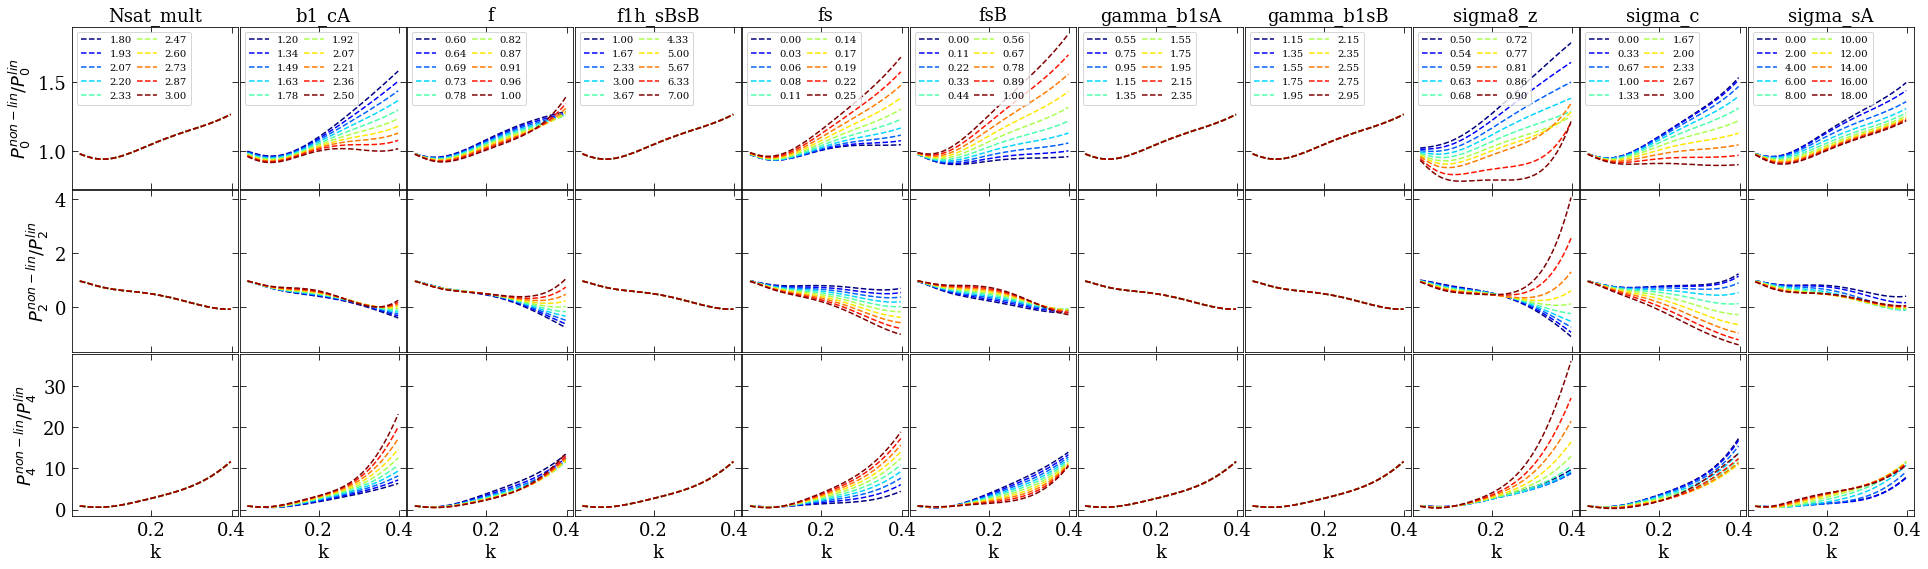

In [22]:
model_param_names = np.array(['Nsat_mult', 'b1_cA', 'f', 'f1h_sBsB', 'fs', 'fsB', 'gamma_b1sA', 'gamma_b1sB', 'sigma8_z', 'sigma_c', 'sigma_sA'], dtype='<U10')

model_params_mean = np.array([2.4 , 1.85, 0.8, 4., 0.125, 0.5, 1.45, 2.05, 0.7, 1.5, 9.0 ])
param_min = np.array([1.8, 1.2, 0.6, 1., 0., 0., 0.55, 1.15, 0.5, 0., 0. ], dtype=np.float32)
param_max = np.array([3.0, 2.5, 1., 7., 0.25, 1., 2.35, 2.95, 0.9, 3., 18. ], dtype=np.float32)

nplt = 10
multipole_order = 3
cmap = plt.cm.jet

nx = model_params_mean.shape[0]
ny = max(multipole_order, 2)

fig, ax = plt.subplots(ny, nx, figsize=(3*nx,3*ny), sharex='col', sharey='row')
plt.subplots_adjust(hspace=0.01, wspace=0.01)
for iparam in range(model_params_mean.shape[0]):
    paramsi = np.tile(model_params_mean, (nplt, 1))

    param_val_vary = np.linspace(param_min[iparam], param_max[iparam], nplt)
    paramsi[:, iparam] = param_val_vary

    paramsi_print = paramsi.copy()

    for i in range(nplt):
        
        c = (param_val_vary[i] - param_min[iparam])/(param_max[iparam] - param_min[iparam])
        # print(param_val_vary[i], param_min[iparam], param_max[iparam], c)
        lab = f'{paramsi_print[i, iparam]:.2f}'

        p = {} # make param dictionary
        for ip, param in enumerate(model_param_names):
            p[param] = paramsi[i][ip]

        update_fitted_model_params(p, d.theory.fit_params)
        update_model_params(p, model_d)

        model_d.b1 = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s
        d.theory.fit_params['b1'].value = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s

        b = model_d.b1
        f = model_d.f    

        linpower_z1.SetSigma8AtZ(model_d.sigma8_z)

        Pell = get_Pells(d, k)
        # Pell_convolved = convolve_Pell(d, k)

        lin = linpower_z1(k)
        lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
        lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
        lin4 = (8/35*f**2)*lin  

        Pell_lin = np.stack([lin0, lin2, lin4])

        Pell_ratio = Pell/Pell_lin    
        Pell_ratio_sig = np.abs(Pell_ratio) * np.sqrt( (P_err/Pell)**2 + (P_err/Pell_lin)**2)

        for m in range(3):
            ax[m, iparam].plot(k, Pell_ratio[m], color=cmap(c), ls='--', label=lab)
 
    ax[0, iparam].legend(loc='upper left', ncol=2, fontsize=10, columnspacing=0.5)
    # if iparam == 0:
   
    ax[0, iparam].set_title(model_param_names[iparam])
    ax[2, iparam].set_xlabel('k')
    
ax[0,0].set_ylabel(f"$P_0^{{non-lin}}/P_0^{{lin}}$")
ax[1,0].set_ylabel(f"$P_2^{{non-lin}}/P_2^{{lin}}$")
ax[2,0].set_ylabel(f"$P_4^{{non-lin}}/P_4^{{lin}}$")

#     ax[0].set_ylabel('$r=P^{non-lin}/P^{lin}$')
plt.savefig("../../figures/pkr_vary_model_params_true.pdf", bbox_inches='tight')

In [20]:
list(sample.values()), list(sample.keys()), 

([2.34029880385561,
  2.1828510407601445,
  0.604445494999829,
  3.553517542138473,
  0.23117395577648567,
  0.19671744631127397,
  1.7679347324978885,
  2.1008305733124755,
  0.6091352683724125,
  1.7326884380754486,
  13.292287658268481],
 ['Nsat_mult',
  'b1_cA',
  'f',
  'f1h_sBsB',
  'fs',
  'fsB',
  'gamma_b1sA',
  'gamma_b1sB',
  'sigma8_z',
  'sigma_c',
  'sigma_sA'])

# Make large sample and save to disk

In [ ]:
from multiprocessing import Pool

import h5py
import time
import os
import math

nsamples = 1000 #000 #256000 #128000
chunksize = 100
print_every = 100

# Get k-bins
kbin_data = np.load("../p0-p2-p4_cov.npz")
k         = kbin_data['k'].astype(np.float32)
P_err     = kbin_data['sigma'].astype(np.float32)

nk   = k.shape[0]
kmin = k[0]
kmax = k[-1]

param_string = '-'.join(list(param_priors.keys())) 

nchunks = math.ceil(nsamples/chunksize)

def generate_chunk(ichunk):
    
    np.random.seed(ichunk)
    model_params = np.empty((chunksize, len(param_priors)), dtype=np.float32)

    pk0_lin    = np.empty((chunksize, nk), dtype=np.float32)
    pk2_lin    = np.empty((chunksize, nk), dtype=np.float32)
    pk4_lin    = np.empty((chunksize, nk), dtype=np.float32)
    pk0_nonlin = np.empty((chunksize, nk), dtype=np.float32)
    pk2_nonlin = np.empty((chunksize, nk), dtype=np.float32)
    pk4_nonlin = np.empty((chunksize, nk), dtype=np.float32)

    # pk0_r = np.empty((nsamples, nk), dtype=np.float32)
    # pk2_r = np.empty((nsamples, nk), dtype=np.float32)

    tstart = time.time()
    for i in range(chunksize):

        sample = sample_params_from_priors(param_priors)
        model_params[i] = list(sample.values())

        update_fitted_model_params(sample, d.theory.fit_params)
        update_model_params(sample, model_d)

        model_d.b1 = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s
        d.theory.fit_params['b1'].value = (1 - model_d.fs)*model_d.b1_c + model_d.fs*model_d.b1_s

        b = model_d.b1
        f = model_d.f    

        linpower_z1.SetSigma8AtZ(model_d.sigma8_z)

        # Re-load best-fit (unconvolved) P_ell's
        Pell = get_Pells(d, k)
        Pell_convolved = convolve_Pell(d, k)

        lin = linpower_z1(k)
        lin0 = (b**2 + 2*b*f/3 + (1/5)*f**2)*lin
        lin2 = (4*b*f/3 + (4/7)*f**2)*lin  
        lin4 = (8/35*f**2)*lin  

        Pell_lin = np.stack([lin0, lin2, lin4])
        # Pell_ratio = Pell/Pell_lin    
        # Pell_ratio_sig = np.abs(Pell_ratio) * np.sqrt( (P_err/Pell)**2 + (P_err/Pell_lin)**2)

        # Non-linear spectra
        pk0_lin[i], pk2_lin[i], pk4_lin[i] = Pell_lin[0], Pell_lin[1], Pell_lin[2]
        pk0_nonlin[i], pk2_nonlin[i], pk4_nonlin[i] = Pell[0], Pell[1], Pell[2]

        # if i % print_every == 0:
        #     print(f"{ichunk}, {i}: time elapsed = {time.time() - tstart}")

    pk0_r = pk0_nonlin/pk0_lin
    pk2_r = pk2_nonlin/pk2_lin
    pk4_r = pk4_nonlin/pk4_lin

    pk0_r_sig = np.abs(pk0_r) * np.sqrt( (P_err[0]/pk0_lin)**2 + (P_err[0]/pk0_nonlin)**2)
    pk2_r_sig = np.abs(pk2_r) * np.sqrt( (P_err[1]/pk2_lin)**2 + (P_err[1]/pk2_nonlin)**2)
    pk4_r_sig = np.abs(pk4_r) * np.sqrt( (P_err[2]/pk4_lin)**2 + (P_err[2]/pk4_nonlin)**2)
    
    print(f"SAVING DATA {ichunk}")
    
    data_dir = '../powerspectra_chunks/'
    # data_path = f'{data_dir}/powerspectra_{param_string}.h5'
    data_path = f'{data_dir}/powerspectra_11param_{ichunk*chunksize:06d}_{(ichunk+1)*chunksize:06d}.h5'

    try: 
        os.remove(data_path)
    except:
        print('file doesnt exist')

    with h5py.File(data_path, 'w') as f:
        f.create_dataset("k", data=k)    
        f.create_dataset("model_params", data=model_params)
        f.create_dataset("model_param_names", data=np.array(list(param_priors.keys())).astype('S'))
        
        f.create_dataset("pk0_sig", data=P_err[0])
        f.create_dataset("pk2_sig", data=P_err[1])
        f.create_dataset("pk4_sig", data=P_err[2])

        f.create_dataset("pk0_lin", data=pk0_lin)
        f.create_dataset("pk2_lin", data=pk2_lin)
        f.create_dataset("pk4_lin", data=pk4_lin)
        
        f.create_dataset("pk0_nonlin", data=pk0_nonlin)
        f.create_dataset("pk2_nonlin", data=pk2_nonlin)
        f.create_dataset("pk4_nonlin", data=pk4_nonlin)

        f.create_dataset("pk0_r", data=pk0_r)
        f.create_dataset("pk2_r", data=pk2_r)
        f.create_dataset("pk4_r", data=pk4_r)

        f.create_dataset("pk0_r_sig", data=pk0_r_sig)
        f.create_dataset("pk2_r_sig", data=pk2_r_sig)
        f.create_dataset("pk4_r_sig", data=pk4_r_sig)

pool = Pool(64)
# with pool:
pool.map(generate_chunk, range(nchunks))
    
pool.close()
pool.join()

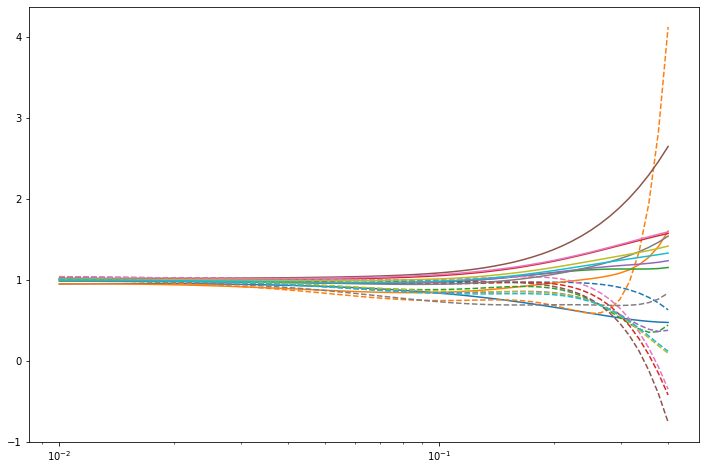

In [27]:
plt.figure(figsize=(12,8))
for i in range(10):
    plt.plot(k, pk0_r[i], color=f"C{i%10}", ls='-')
    plt.plot(k, pk2_r[i], color=f"C{i%10}", ls='--')

plt.xscale('log')

In [10]:
# Change the P(k) model's parameters

In [31]:
# Increase sig8 to 0.8
model_d.sigma8_z = 0.8

In [32]:
# Re-load best-fit (unconvolved) P_ell's
tstart = time.time()

k_pole_highk = np.logspace(-3, 0, 1000)
P0_highk_d = d.theory.model.poles(k_pole_highk , 0)
P2_highk_d = d.theory.model.poles(k_pole_highk , 2)
# P4_highk_d = d.theory.model.poles(k_pole_highk , 4)

print("0: ", time.time()-tstart)


0:  2.8475089073181152


Text(0.5, 0, 'k')

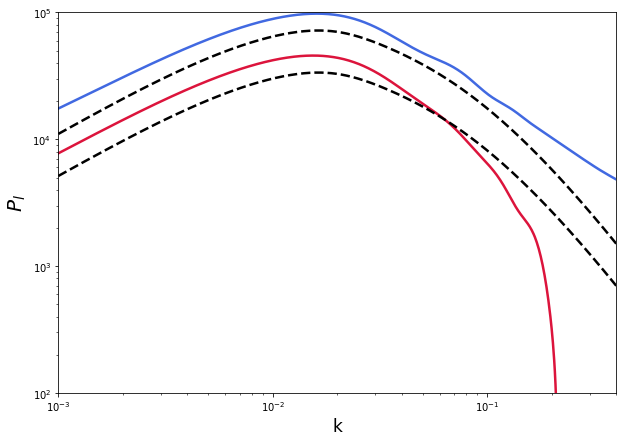

In [33]:
# Plot k vs. P_l

plt.figure(figsize=(10,7))
plt.loglog(k_pole_highk, np.array(P0_highk_d[:,0]), '-', color = 'royalblue', lw=2.5)
plt.loglog(k_pole_highk, ((b**2+2*b*f/3+(1/5)*f**2)*linpower_z1(k_pole_highk)), '--', color = 'black', lw=2.5)

plt.loglog(k_pole_highk, np.array(P2_highk_d[:,0]), '-', color = 'crimson', lw=2.5)
plt.plot(k_pole_highk, (4*b*f/3+(4/7)*f**2)*linpower_z1(k_pole_highk), '--', color = 'black', lw=2.5)

plt.xlim(1e-3, 0.4)
plt.ylim(1e2, 1e5)
plt.ylabel('$P_l$', fontsize=20)
plt.xlabel('k', fontsize=17)